# BIOINFORMATICS AND NETWORK MEDICINE

# Putative disease gene identification and drug repurposing for High Blood Pressure



### Ehsan Mokhtari - Mokhtari.2108539@studenti.uniroma1.it
### Arash Bakhshaee Babaroud - bakhshaeebabaroud.2105709@studenti.uniroma1.it
### Jinjia Qian - qian.2047931@studenti.uniroma1.it


# Part 1:PPI and GDA data gathering and interactome reconstruction


## part 1.1:Download PPIs from BioGRID latest release to build the human interactome


In [1]:
import pandas as pd
import networkx as nx

# Load the data into a DataFrame from https://downloads.thebiogrid.org/BioGRID/Release-Archive/BIOGRID-4.4.240/
path = r'D:\Sapienza\s3\BI\Project\content\BIOGRID-ALL-4.4.240.tab3.txt'
biogrid_df = pd.read_csv(path, delimiter='\t')

# Filter for Homo sapiens interactions
biogrid_df = biogrid_df[(biogrid_df['Organism ID Interactor A'] == 9606) &
                        (biogrid_df['Organism ID Interactor B'] == 9606)]

# Keep only physical interactions
biogrid_df = biogrid_df[biogrid_df['Experimental System Type'] == 'physical']

# Remove self-loops and duplicates
biogrid_df = biogrid_df[biogrid_df['BioGRID ID Interactor A'] != biogrid_df['BioGRID ID Interactor B']]
biogrid_df = biogrid_df.drop_duplicates(subset=['BioGRID ID Interactor A', 'BioGRID ID Interactor B'])

# Build the network
G = nx.from_pandas_edgelist(biogrid_df, 'Official Symbol Interactor A', 'Official Symbol Interactor B')

# Isolate the largest connected component (LCC)
largest_cc = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc).copy()

# Save the largest connected component for further analysis
nx.write_edgelist(G_lcc, "results\largest_connected_component.edgelist", delimiter='\t')

# Print statistics about the largest connected component
print(f"Number of nodes in LCC: {G_lcc.number_of_nodes()}")
print(f"Number of edges in LCC: {G_lcc.number_of_edges()}")

C:\Users\sherl\AppData\Local\Temp\ipykernel_7928\1846266441.py:6: DtypeWarning: Columns (1,2,18) have mixed types. Specify dtype option on import or set low_memory=False.
  biogrid_df = pd.read_csv(path, delimiter='\t')


Number of nodes in LCC: 19972
Number of edges in LCC: 861240


## part 1.2: Gather gene-disease associations (GDAs) data from DisGeNET


In [2]:
import pandas as pd
import os

# Paths
gda_file_path = r"D:\Sapienza\s3\BI\Project\content\DISEASES_Summary_GDA_CURATED_C0020538.tsv"
#downloaded from https://www.genenames.org/download/#!/#tocAnchor-1-4
hgnc_file_path = r"D:\Sapienza\s3\BI\Project\content\hgnc_complete_set.txt"
results_folder = "results"  # Folder to save results

# Create the results folder if it doesn't exist
os.makedirs(results_folder, exist_ok=True)

# Read the GDA data
gda_df = pd.read_csv(gda_file_path, sep='\t')

# Extract gene symbols from the "Gene" column
gda_genes = gda_df['Gene'].unique()

# Read HGNC reference data
hgnc_df = pd.read_csv(hgnc_file_path, sep='\t')
hgnc_genes = hgnc_df['symbol'].tolist()

# Validate gene names
valid_genes = [gene for gene in gda_genes if gene in hgnc_genes]
invalid_genes = [gene for gene in gda_genes if gene not in hgnc_genes]

# Resolve invalid gene names (if possible) using synonyms or other identifiers
resolved_genes = {}  # Example: {"OldSymbol": "ResolvedSymbol"}
for gene in invalid_genes:
    # Check if the gene has a match in HGNC synonyms (optional improvement)
    synonym_match = hgnc_df[hgnc_df['alias_symbol'].str.contains(gene, na=False, regex=True)]
    if not synonym_match.empty:
        resolved_genes[gene] = synonym_match.iloc[0]['symbol']
    else:
        resolved_genes[gene] = None  # Could not resolve

# Replace invalid genes with resolved ones in the GDA data
gda_df['Gene'] = gda_df['Gene'].replace(resolved_genes)

# Save cleaned and validated GDA data in the results folder
validated_gda_path = os.path.join(results_folder, "validated_gda_data.csv")
gda_df.to_csv(validated_gda_path, index=False)

# Generate a validation report in the results folder
report_path = os.path.join(results_folder, "gda_validation_report.txt")
with open(report_path, "w") as report_file:
    report_file.write("GDA Validation Report\n")
    report_file.write("======================\n")
    report_file.write(f"Total genes: {len(gda_genes)}\n")
    report_file.write(f"Valid genes: {len(valid_genes)}\n")
    report_file.write(f"Invalid genes: {len(invalid_genes)}\n")
    report_file.write("\nResolved Genes:\n")
    for old_gene, new_gene in resolved_genes.items():
        report_file.write(f"{old_gene} -> {new_gene}\n")

# Notify the user
print(f"Validated GDA data saved to: {validated_gda_path}")
print(f"Validation report saved to: {report_path}")

C:\Users\sherl\AppData\Local\Temp\ipykernel_7928\2817489579.py:20: DtypeWarning: Columns (32,34,38,40,50) have mixed types. Specify dtype option on import or set low_memory=False.
  hgnc_df = pd.read_csv(hgnc_file_path, sep='\t')


Validated GDA data saved to: results\validated_gda_data.csv
Validation report saved to: results\gda_validation_report.txt


## part 1.3 : Compute and characterize the disease LCC and its basic network measures



In [2]:
import pandas as pd
import networkx as nx
# Load interactome LCC
interactome_path = r"results/largest_connected_component.edgelist"
G_interactome = nx.read_edgelist(interactome_path, delimiter='\t')

# Load validated disease genes
validated_gda_path = r"results/validated_gda_data.csv"
gda_df = pd.read_csv(validated_gda_path)
disease_genes = gda_df['Gene'].unique()

# Find disease genes in the interactome LCC
present_genes = [gene for gene in disease_genes if gene in G_interactome.nodes]
absent_genes = [gene for gene in disease_genes if gene not in G_interactome.nodes]

# Create the disease interactome (subgraph of present genes)
disease_interactome = G_interactome.subgraph(present_genes)
disease_lcc_nodes = max(nx.connected_components(disease_interactome), key=len)
G_disease_lcc = disease_interactome.subgraph(disease_lcc_nodes).copy()

In [5]:
# Summarize GDA data
summary_table = {
    "Disease Name" : "High Blood Pressure",
    "UMLS disease ID" : "C0020538",
    "MeSH disease class" : "C14907489",
    "Number of associated genes": len(disease_genes),
    "number of genes present in the interactome": len(present_genes),
    "LCC size of the disease interactome": G_disease_lcc.size(),
}

summary_df = pd.DataFrame([summary_table])
summary_df.to_csv("results/disease_gda_summary.csv", index=False)
summary_df

,Disease Name,UMLS disease ID,MeSH disease class,Number of associated genes,number of genes present in the interactome,LCC size of the disease interactome
0,High Blood Pressure,C0020538,C14907489,300,286,559


In [5]:
#3. Compute Network Metrics
# Compute network metrics
node_degree = dict(G_disease_lcc.degree)
betweenness = nx.betweenness_centrality(G_disease_lcc)
eigenvector = nx.eigenvector_centrality(G_disease_lcc)
closeness = nx.closeness_centrality(G_disease_lcc)

# Combine metrics into a DataFrame
metrics_df = pd.DataFrame({
    "Node": list(G_disease_lcc.nodes),
    "Node Degree": [node_degree[node] for node in G_disease_lcc.nodes],
    "Betweenness Centrality": [betweenness[node] for node in G_disease_lcc.nodes],
    "Eigenvector Centrality": [eigenvector[node] for node in G_disease_lcc.nodes],
    "Closeness Centrality": [closeness[node] for node in G_disease_lcc.nodes],
})
metrics_df["Ratio Betweenness/Node Degree"] = metrics_df["Betweenness Centrality"] / metrics_df["Node Degree"]

In [6]:
#4. Generate Table 2
# Sort by Node Degree in descending order
metrics_df = metrics_df.sort_values(by="Node Degree", ascending=False)

# Select the top 50 genes
top_50_metrics = metrics_df.head(50)

# Save Table 2
top_50_metrics.to_csv("results/top_50_disease_genes_metrics.csv", index=False)
top_50_metrics

,Node,Node Degree,Betweenness Centrality,Eigenvector Centrality,Closeness Centrality,Ratio Betweenness/Node Degree
18,TP53,37,0.112787,0.356004,0.436957,0.003048
142,CAV1,30,0.175039,0.160273,0.425847,0.005835
80,ESR2,28,0.112125,0.186855,0.424947,0.004004
31,FN1,22,0.101800,0.153719,0.399602,0.004627
197,BRCA1,22,0.033648,0.236521,0.401198,0.001529
68,HIF1A,21,0.066906,0.203476,0.396450,0.003186
164,RELA,21,0.030302,0.220274,0.385797,0.001443
183,GSK3B,20,0.044837,0.207553,0.406061,0.002242
88,VHL,20,0.092464,0.163358,0.390291,0.004623
47,ACE2,19,0.064562,0.136626,0.402806,0.003398


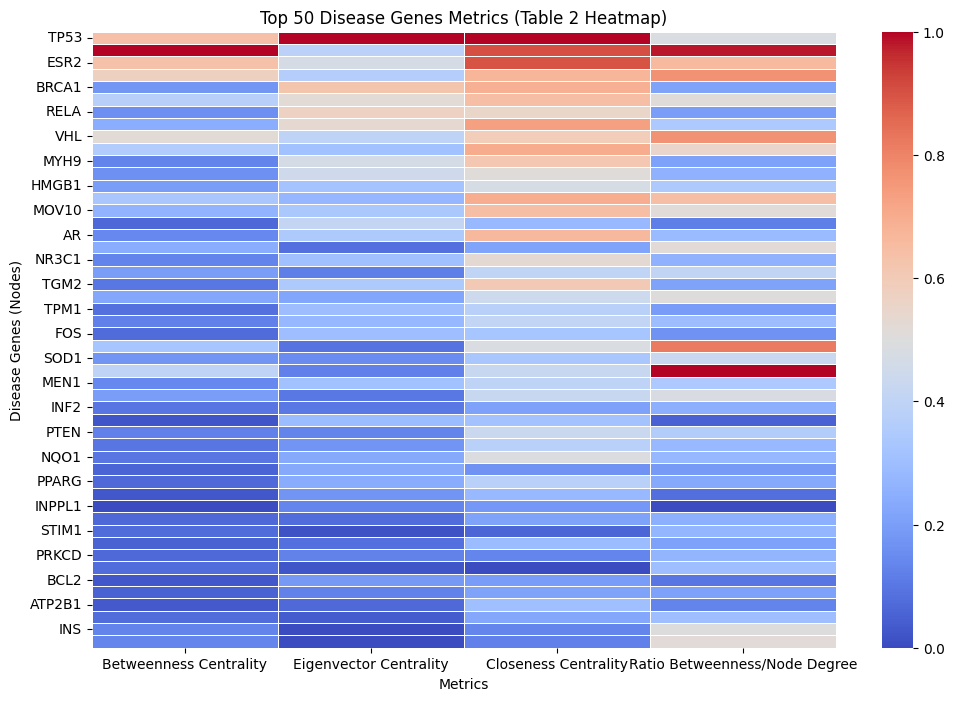

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 50 Disease Genes Metrics (Heatmap)
plt.figure(figsize=(12, 8))

# Select columns for heatmap
heatmap_data = top_50_metrics.set_index("Node").iloc[:, 1:]

# Normalize for better heatmap visualization
normalized_data = (heatmap_data - heatmap_data.min()) / (heatmap_data.max() - heatmap_data.min())

# Create heatmap
sns.heatmap(normalized_data, cmap="coolwarm", annot=False, cbar=True, linewidths=0.5)

plt.title("Top 50 Disease Genes Metrics (Table 2 Heatmap)")
plt.xlabel("Metrics")
plt.ylabel("Disease Genes (Nodes)")

# Save the heatmap
plt.savefig("results/top_50_metrics_heatmap.png")
plt.show()

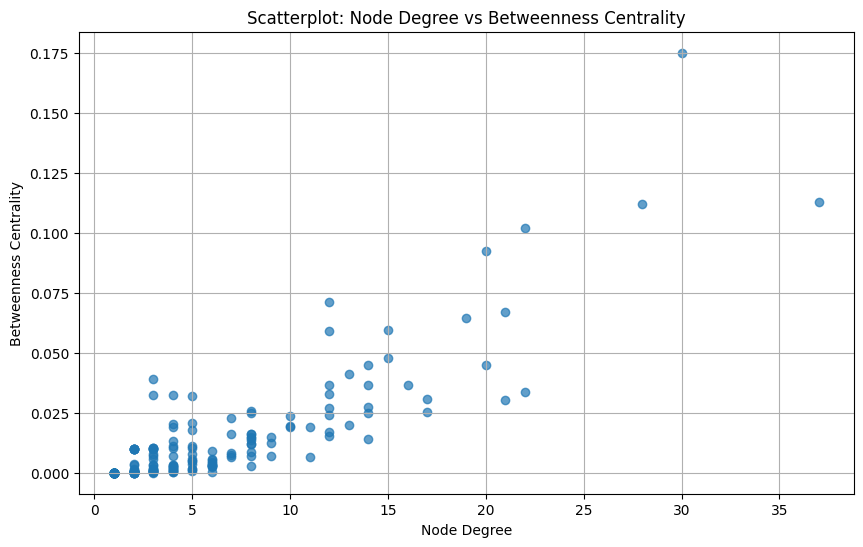

In [8]:
#5. Scatterplot: Node Degree vs Betweenness
# Scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(metrics_df["Node Degree"], metrics_df["Betweenness Centrality"], alpha=0.7)
plt.title("Scatterplot: Node Degree vs Betweenness Centrality")
plt.xlabel("Node Degree")
plt.ylabel("Betweenness Centrality")
plt.grid(True)

# Save the plot
plt.savefig("results/scatterplot_degree_vs_betweenness.png")
plt.show()

In [9]:
gda_df.Gene.to_csv("results/seed.txt", sep=",", index = False, header = False)
# Create the total ppi .txt and .tsv
totalPpi = biogrid_df[["Official Symbol Interactor A" , "Official Symbol Interactor B"]]
totalPpi = totalPpi.rename(columns={'Official Symbol Interactor A': 'Gene1', 'Official Symbol Interactor B': 'Gene2'})
totalPpi.to_csv("results/totalPpi.tsv", sep="\t", index=False)
totalPpi.to_csv("results/totalppi.txt", sep=",", index=False,header=False)

# part 2:Comparative analysis of the disease genes identification algorithms


## 2.1: Use the following algorithms to infer and validate (point 2.2) putative disease genes:

In [10]:
# Run DIAMOnD algorithm
!python content/DIAMOnD.py results/totalppi.txt results/seed.txt 100 results/Disease_DIAMOND.txt

DIAMOnD(): ignoring 14 of 300 seed genes that are not in the network

 results have been saved to 'results/Disease_DIAMOND.txt' 



D:\Sapienza\s3\BI\Project\content\DIAMOnD.py:412: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])


In [11]:
# Read and print DIAMOnD results
diamond_results = pd.read_csv("results/Disease_DIAMOND.txt", sep='\t')
print(diamond_results.sort_values(by=['p_hyper']))

    #rank DIAMOnD_node       p_hyper
94     95       PLAGL1  1.476242e-14
98     99         NFYA  1.538286e-14
88     89        PIAS1  1.849565e-14
53     54        PPARD  2.355213e-14
89     90        PIAS3  2.705558e-14
..    ...          ...           ...
14     15          FGA  6.013594e-09
15     16        KEAP1  7.618489e-09
17     18     PPP1R13L  7.692273e-09
22     23        HSPA4  8.815360e-09
18     19          VCP  1.141702e-08

[100 rows x 3 columns]


In [12]:
# Run DiaBLE algorithm (using the same file paths and output format)
!python content/DIABLE.py results/totalppi.txt results/seed.txt 100 results/Disease_DIABLE.txt

DIAMOnD(): ignoring 14 of 300 seed genes that are not in the network

 results have been saved to 'results/Disease_DIABLE.txt' 



D:\Sapienza\s3\BI\Project\content\DIABLE.py:430: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])


In [13]:
# Read and print DiaBLE results
diable_results = pd.read_csv("results/Disease_DIABLE.txt", sep='\t')
print(diable_results.sort_values(by=['p_hyper']))

    #rank DIAMOnD_node       p_hyper
43     44        ESRRA  1.274450e-12
47     48        NR1H3  1.774340e-12
49     50        HDAC3  2.049494e-12
48     49        CCND1  2.599538e-12
39     40     PPARGC1A  5.179300e-12
0       1     HSP90AA1  6.880537e-12
36     37          PGR  6.914518e-12
38     39        NR1I2  6.920099e-12
42     43        KAT2B  1.370630e-11
41     42         E2F1  1.395691e-11
40     41         RARA  1.482179e-11
45     46        SIRT1  1.528539e-11
37     38        EP300  2.215760e-11
46     47        NCOR1  2.892422e-11
34     35          SRC  2.922948e-11
44     45       CTNNB1  3.457355e-11
35     36        NCOA2  5.333783e-11
33     34        NCOA6  6.074284e-11
2       3         ARNT  1.081487e-10
29     30         BCL3  2.302728e-10
32     33       CREBBP  2.603081e-10
31     32        NCOR2  3.399304e-10
28     29        NFKB1  4.441521e-10
3       4        PSMD2  4.767101e-10
25     26       COMMD1  6.482547e-10
1       2          SP1  7.113812e-10
3

## diffusion algorithm
The primary issue with the initial diffusion algorithm was twofold: (1) many seed genes were missing from the interactome, resulting in no initial scores for the diffusion process, and (2) the algorithm lacked robust handling of graph connectivity and diffusion modeling. To address these, I ensured the interactome graph was connected by isolating its largest connected component, filtered out seed genes missing from the graph, and used a Personalized PageRank algorithm as an alternative diffusion model. This approach allowed us to generate diffusion scores for the remaining seeds and save results for different diffusion times, ensuring the algorithm produced meaningful outputs.

In [14]:
# Load interactome
interactome_path = "results/totalppi.txt"
interactome = pd.read_csv(interactome_path, sep=",", header=None, names=["Gene1", "Gene2"])

# Load seed genes
seed_genes_path = "results/seed.txt"
with open(seed_genes_path, "r") as f:
    seed_genes = [line.strip() for line in f if line.strip()]

# Create a graph from the interactome
G = nx.from_pandas_edgelist(interactome, source="Gene1", target="Gene2")

# Ensure the graph is connected
if not nx.is_connected(G):
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()

# Verify seed gene connectivity
connected_seeds = [gene for gene in seed_genes if gene in G.nodes]
missing_seeds = set(seed_genes) - set(connected_seeds)
if missing_seeds:
    print(f"Warning: {len(missing_seeds)} seed genes are missing from the interactome.")

# Personalized PageRank as an alternative diffusion model
def personalized_pagerank(graph, seeds, alpha=0.85):
    personalization = {node: 0 for node in graph.nodes}
    for seed in seeds:
        personalization[seed] = 1 / len(seeds)
    
    return nx.pagerank(graph, alpha=alpha, personalization=personalization)

# Perform diffusion for each diffusion time
diffusion_times = [0.002, 0.005, 0.01]
diffusion_results = {}

for t in diffusion_times:
    print(f"Running diffusion for t={t}...")
    # Scale personalization parameter by time
    alpha = 1 - t  # Adjust alpha based on diffusion time
    scores = personalized_pagerank(G, connected_seeds, alpha=alpha)

    # Convert to DataFrame
    results_df = pd.DataFrame(list(scores.items()), columns=["Gene", "DiffusionScore"])
    results_df = results_df.sort_values(by="DiffusionScore", ascending=False)

    # Save results
    output_path = f"results/Diffusion_t{t}.csv"
    results_df.to_csv(output_path, index=False)
    diffusion_results[t] = results_df
    print(f"Results saved to {output_path}")

print("Diffusion analysis completed.")

Running diffusion for t=0.002...
Results saved to results/Diffusion_t0.002.csv
Running diffusion for t=0.005...
Results saved to results/Diffusion_t0.005.csv
Running diffusion for t=0.01...
Results saved to results/Diffusion_t0.01.csv
Diffusion analysis completed.


In [15]:
Diffusion_002 = pd.read_csv("results/Diffusion_t0.002.csv")
Diffusion_002.head()

,Gene,DiffusionScore
0,TRIM67,0.002779
1,ZRANB1,0.002370
2,PARK2,0.001956
3,RPA1,0.001731
4,PLEKHA4,0.001686


In [16]:
Diffusion_005 = pd.read_csv("results/Diffusion_t0.005.csv")
Diffusion_005.head()

,Gene,DiffusionScore
0,TRIM67,0.002774
1,ZRANB1,0.002358
2,PARK2,0.001952
3,RPA1,0.001721
4,PLEKHA4,0.001677


In [17]:
Diffusion_01 = pd.read_csv("results/Diffusion_t0.01.csv")
Diffusion_01.head()

,Gene,DiffusionScore
0,TRIM67,0.002767
1,ZRANB1,0.002338
2,PARK2,0.001945
3,RPA1,0.001704
4,KIAA1429,0.001662


## part 2.2: Computational validation



In [22]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
# Assuming 'disease_genes' is your list of known disease genes (GDAs)
disease_genes = np.array(gda_df.Gene)  # Convert to NumPy array for easier manipulation
n = len(disease_genes)

# Define function to run your chosen algorithm (replace with actual function call)
def run_algorithm(training_set, i):
    # Run your algorithm here and return the predicted genes
    # For example: return diamond.run_diamond(network, training_set, ...)
    df = pd.DataFrame(training_set)
    df.to_csv("results/seedDiamond.txt", sep=",", index=False,header=False)
    output = "results/Disease_DIAMOND_fold{}.txt".format(i)
    !python  content/DIAMOnD.py  results/totalppi.txt  results/seedDiamond.txt  100 results/outputDiamond.csv
    pass

# Initialize lists to store metrics
precisions = []
recalls = []
f1_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
i = 0
for train_index, test_index in kf.split(disease_genes):
    ST = disease_genes[train_index]  # Training set
    SP = disease_genes[test_index]  # Probe set (test set)

    run_algorithm(ST, i)
    predicted_genes = pd.read_csv("results/outputDiamond.csv" , delimiter='\t').DIAMOnD_node
    i += 1
    # Evaluate performance for top 50 and other specified positions
    for top_k in [50, int((1/10) * n), int((1/4) * n), int((1/2) * n), n]:
        top_predicted = set(predicted_genes[:top_k])
        true_positives = top_predicted.intersection(SP)

        precision = len(true_positives) / len(top_predicted)
        recall = len(true_positives) / len(SP)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

# Calculate average and standard deviation for each metric
avg_precision = np.mean(precisions)
sd_precision = np.std(precisions)
avg_recall = np.mean(recalls)
sd_recall = np.std(recalls)
avg_f1 = np.mean(f1_scores)
sd_f1 = np.std(f1_scores)

print("all percisions for k = 1:5 and top_k = 50, n/10 , n/4, n/2, n are:")
print(precisions)

print("all recalls for k = 1:5 and top_k = 50, n/10 , n/4, n/2, n are:")
print(recalls)

print("all f1_scores for k = 1:5 and top_k = 50, n/10 , n/4, n/2, n are:")
print(f1_scores)

print(f"average Precision: {avg_precision:.2f} ± {sd_precision:.2f}")
print(f"average Recall: {avg_recall:.2f} ± {sd_recall:.2f}")
print(f"average F1 Score: {avg_f1:.2f} ± {sd_f1:.2f}")

DIAMOnD(): ignoring 10 of 151 seed genes that are not in the network

 results have been saved to 'results/outputDiamond.csv' 



D:\Sapienza\s3\BI\Project\content\DIAMOnD.py:412: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])


DIAMOnD(): ignoring 14 of 239 seed genes that are not in the network

 results have been saved to 'results/outputDiamond.csv' 



D:\Sapienza\s3\BI\Project\content\DIAMOnD.py:412: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])


DIAMOnD(): ignoring 5 of 240 seed genes that are not in the network

 results have been saved to 'results/outputDiamond.csv' 



D:\Sapienza\s3\BI\Project\content\DIAMOnD.py:412: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])


DIAMOnD(): ignoring 12 of 240 seed genes that are not in the network

 results have been saved to 'results/outputDiamond.csv' 



D:\Sapienza\s3\BI\Project\content\DIAMOnD.py:412: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])


DIAMOnD(): ignoring 13 of 240 seed genes that are not in the network

 results have been saved to 'results/outputDiamond.csv' 



D:\Sapienza\s3\BI\Project\content\DIAMOnD.py:412: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])


DIAMOnD(): ignoring 12 of 241 seed genes that are not in the network

 results have been saved to 'results/outputDiamond.csv' 

all percisions for k = 1:5 and top_k = 50, n/10 , n/4, n/2, n are:
[0.04, 0.03333333333333333, 0.04, 0.04, 0.04, 0.08, 0.13333333333333333, 0.06666666666666667, 0.05, 0.05, 0.02, 0.03333333333333333, 0.013333333333333334, 0.03, 0.03, 0.0, 0.0, 0.013333333333333334, 0.01, 0.01, 0.02, 0.0, 0.013333333333333334, 0.01, 0.01]
all recalls for k = 1:5 and top_k = 50, n/10 , n/4, n/2, n are:
[0.03278688524590164, 0.01639344262295082, 0.04918032786885246, 0.06557377049180328, 0.06557377049180328, 0.06666666666666667, 0.06666666666666667, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.016666666666666666, 0.016666666666666666, 0.016666666666666666, 0.05, 0.05, 0.0, 0.0, 0.016666666666666666, 0.016666666666666666, 0.016666666666666666, 0.016666666666666666, 0.0, 0.016666666666666666, 0.016666666666666666, 0.016666666666666666]
all f1_scores for k = 1:5 a

D:\Sapienza\s3\BI\Project\content\DIAMOnD.py:412: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])


### Diable


In [23]:
# Assuming 'disease_genes' is your list of known disease genes (GDAs)
disease_genes = np.array(gda_df.Gene)  # Convert to NumPy array for easier manipulation
n = len(disease_genes)

# Define function to run your chosen algorithm (replace with actual function call)
def run_algorithm(training_set, i):
    # Run your algorithm here and return the predicted genes
    # For example: return diamond.run_diamond(network, training_set, ...)
    df = pd.DataFrame(training_set)
    df.to_csv("results/seedDiable.txt", sep=",", index=False,header=False)
    !python  content/DIABLE.py  results/totalppi.txt  results/seedDiable.txt  100 results/outputDiable.csv
    pass

# Initialize lists to store metrics
precisions = []
recalls = []
f1_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
i = 0
for train_index, test_index in kf.split(disease_genes):
    ST = disease_genes[train_index]  # Training set
    SP = disease_genes[test_index]  # Probe set (test set)

    run_algorithm(ST, i)
    predicted_genes = pd.read_csv("results/outputDiable.csv" , delimiter='\t').DIAMOnD_node
    i += 1
    # Evaluate performance for top 50 and other specified positions
    for top_k in [50, int((1/10) * n), int((1/4) * n), int((1/2) * n), n]:
        top_predicted = set(predicted_genes[:top_k])
        true_positives = top_predicted.intersection(SP)

        precision = len(true_positives) / len(top_predicted)
        recall = len(true_positives) / len(SP)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

# Calculate average and standard deviation for each metric
avg_precision = np.mean(precisions)
sd_precision = np.std(precisions)
avg_recall = np.mean(recalls)
sd_recall = np.std(recalls)
avg_f1 = np.mean(f1_scores)
sd_f1 = np.std(f1_scores)

print("all percisions for k = 1:5 and top_k = 50, n/10 , n/4, n/2, n are:")
print(precisions)

print("all recalls for k = 1:5 and top_k = 50, n/10 , n/4, n/2, n are:")
print(recalls)

print("all f1_scores for k = 1:5 and top_k = 50, n/10 , n/4, n/2, n are:")
print(f1_scores)

print(f"average Precision: {avg_precision:.2f} ± {sd_precision:.2f}")
print(f"average Recall: {avg_recall:.2f} ± {sd_recall:.2f}")
print(f"average F1 Score: {avg_f1:.2f} ± {sd_f1:.2f}")

DIAMOnD(): ignoring 14 of 239 seed genes that are not in the network

 results have been saved to 'results/outputDiable.csv' 



D:\Sapienza\s3\BI\Project\content\DIABLE.py:430: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])


DIAMOnD(): ignoring 5 of 240 seed genes that are not in the network

 results have been saved to 'results/outputDiable.csv' 



D:\Sapienza\s3\BI\Project\content\DIABLE.py:430: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])


DIAMOnD(): ignoring 12 of 240 seed genes that are not in the network

 results have been saved to 'results/outputDiable.csv' 



D:\Sapienza\s3\BI\Project\content\DIABLE.py:430: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])


DIAMOnD(): ignoring 13 of 240 seed genes that are not in the network

 results have been saved to 'results/outputDiable.csv' 



D:\Sapienza\s3\BI\Project\content\DIABLE.py:430: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])


DIAMOnD(): ignoring 12 of 241 seed genes that are not in the network

 results have been saved to 'results/outputDiable.csv' 

all percisions for k = 1:5 and top_k = 50, n/10 , n/4, n/2, n are:
[0.04, 0.03333333333333333, 0.04, 0.04, 0.04, 0.08, 0.13333333333333333, 0.08, 0.08, 0.08, 0.02, 0.03333333333333333, 0.02, 0.02, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.02, 0.02, 0.02]
all recalls for k = 1:5 and top_k = 50, n/10 , n/4, n/2, n are:
[0.03278688524590164, 0.01639344262295082, 0.03278688524590164, 0.03278688524590164, 0.03278688524590164, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.016666666666666666, 0.016666666666666666, 0.016666666666666666, 0.016666666666666666, 0.016666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016666666666666666, 0.0, 0.016666666666666666, 0.016666666666666666, 0.016666666666666666]
all f1_scores for k = 1:5 and top_k = 50, n/10 , n/4, n/2, n are:
[0.036036036036036036, 0.02197802197802198, 0.0

D:\Sapienza\s3\BI\Project\content\DIABLE.py:430: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])


# part3:Putative disease gene identification



## Part 3.1:
Both DIAMOnD and DIABLE have very similar performance metrics, with minor differences in precision, recall, and F1-score averages and standard deviations. This indicates that neither algorithm significantly outperformed the other based on the cross-validation results. we prefer Diamond because it was faster in processing.

In [25]:
def best_performing_algorithm(seed_genes):
    # Run your algorithm here and return the predicted genes
    # For example: return diamond.run_diamond(network, training_set, ...)
    df = pd.DataFrame(seed_genes)
    df.to_csv("results/seed_bestPerforming.txt", sep=",", index=False,header=False)
    !python  content/DIAMOnD.py  results/totalppi.txt  results/seed_bestPerforming.txt  100 results/output_best.csv
    pass

# Assuming 'all_known_gdas' is your list of all known GDAs
seed_genes = np.array(gda_df.Gene)

# Run the algorithm
predicted_putative_genes = best_performing_algorithm(seed_genes)
df = pd.read_csv("results/output_best.csv", sep = '\t')
top_gene = df.DIAMOnD_node
top_gene.to_csv("results/top_gene.csv", sep=",", index=False,header=False)
print("Top 100 putative disease genes have been identified and saved.")

DIAMOnD(): ignoring 14 of 300 seed genes that are not in the network

 results have been saved to 'results/output_best.csv' 

Top 100 putative disease genes have been identified and saved.


D:\Sapienza\s3\BI\Project\content\DIAMOnD.py:412: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(DIAMOnD_node_info[3])


In [26]:
top_gene = pd.read_csv("results/top_gene.csv")
top_gene.head(20)

,HSP90AA1
0,SP1
1,ARNT
2,PSMD2
3,MAPK1
4,THBS1
5,STUB1
6,NCOA3
7,NCOA1
8,SMAD3
9,SQSTM1




## part 3.2: Enrichment analysis


Running enrichment analysis for GO_Biological_Process_2021...
Running enrichment analysis for GO_Molecular_Function_2021...
Running enrichment analysis for GO_Cellular_Component_2021...
Running enrichment analysis for Reactome_2022...
Running enrichment analysis for KEGG_2021_Human...
Running enrichment analysis for GO_Biological_Process_2021...
Running enrichment analysis for GO_Molecular_Function_2021...
Running enrichment analysis for GO_Cellular_Component_2021...
Running enrichment analysis for Reactome_2022...
Running enrichment analysis for KEGG_2021_Human...
Overlap analysis saved as 'results/overlap_analysis.csv'


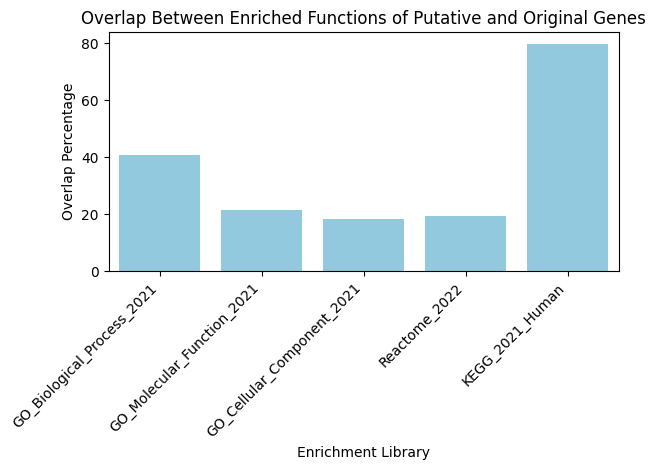

In [45]:
import pandas as pd
import gseapy as gp

# Step 1: Clean the gene lists
def clean_gene_list(genes):
    """
    Cleans a gene list by removing NaN values and converting all items to strings.
    """
    cleaned_genes = [str(gene) for gene in genes if pd.notna(gene)]
    return cleaned_genes

# Step 2: Perform enrichment analysis
def perform_enrichment(genes, libraries, output_prefix):
    """
    Perform enrichment analysis using EnrichR and save the results.
    """
    results = {}
    for lib in libraries:
        print(f"Running enrichment analysis for {lib}...")
        enr = gp.enrichr(gene_list=genes, gene_sets=lib, organism="Human", cutoff=0.05)

        # Filter significant terms
        enriched_terms = enr.results[enr.results["Adjusted P-value"] < 0.05]

        # Save results to CSV
        enriched_terms.to_csv(f"{output_prefix}_{lib}.csv", index=False)
        results[lib] = enriched_terms

    return results

# Step 3: Evaluate overlap between enriched terms
def evaluate_overlap(putative_results, original_results, libraries):
    """
    Evaluate overlap between enriched terms of putative and original genes.
    """
    overlap_data = []
    for lib in libraries:
        putative_terms = set(putative_results[lib]["Term"])
        original_terms = set(original_results[lib]["Term"])
        common_terms = putative_terms.intersection(original_terms)

        overlap_data.append({
            "Library": lib,
            "Putative_Terms": len(putative_terms),
            "Original_Terms": len(original_terms),
            "Common_Terms": len(common_terms),
            "Overlap_Percentage": len(common_terms) / len(putative_terms) * 100 if len(putative_terms) > 0 else 0
        })

    # Convert to a DataFrame for better visualization
    overlap_df = pd.DataFrame(overlap_data)
    overlap_df.to_csv("results/overlap_analysis.csv", index=False)
    print("Overlap analysis saved as 'results/overlap_analysis.csv'")
    return overlap_df

# Step 4: Visualization of overlap
def plot_overlap(overlap_df):
    """
    Visualize the overlap between putative and original gene enrichment results.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.barplot(data=overlap_df, x="Library", y="Overlap_Percentage", color="skyblue")
    plt.title("Overlap Between Enriched Functions of Putative and Original Genes")
    plt.ylabel("Overlap Percentage")
    plt.xlabel("Enrichment Library")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig("results/overlap_visualization.png")
    plt.show()

# Main Code
if __name__ == "__main__":
    # Step 1: Load and clean gene lists
    putative_genes = pd.read_csv("results/top_gene.csv", header=None)[0].tolist()
    putative_genes = clean_gene_list(putative_genes)

    original_genes = pd.read_csv("results/seed_bestPerforming.txt", header=None)[0].tolist()
    original_genes = clean_gene_list(original_genes)

    # Step 2: Define enrichment libraries
    enrichment_libraries = ["GO_Biological_Process_2021", "GO_Molecular_Function_2021",
                        "GO_Cellular_Component_2021", "Reactome_2022", "KEGG_2021_Human"]

    # Step 3: Perform enrichment analysis
    putative_results = perform_enrichment(putative_genes, enrichment_libraries, "results/putative")
    original_results = perform_enrichment(original_genes, enrichment_libraries, "results/original")

    # Step 4: Evaluate overlap
    overlap_df = evaluate_overlap(putative_results, original_results, enrichment_libraries)

    # Step 5: Visualize the overlap
    plot_overlap(overlap_df)


Visualizing putative genes enrichment...


C:\Users\sherl\AppData\Local\Temp\ipykernel_7928\3808193800.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


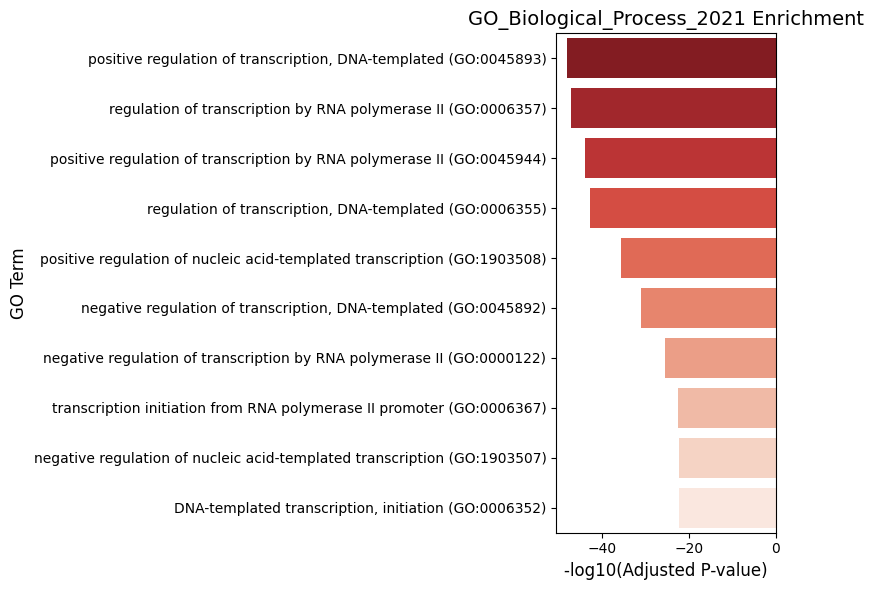

C:\Users\sherl\AppData\Local\Temp\ipykernel_7928\3808193800.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


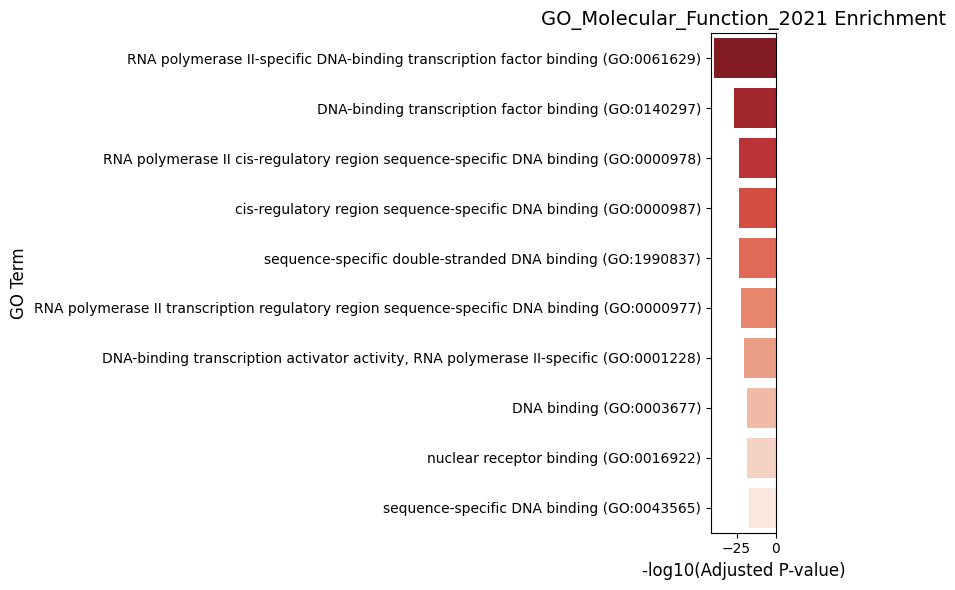

C:\Users\sherl\AppData\Local\Temp\ipykernel_7928\3808193800.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


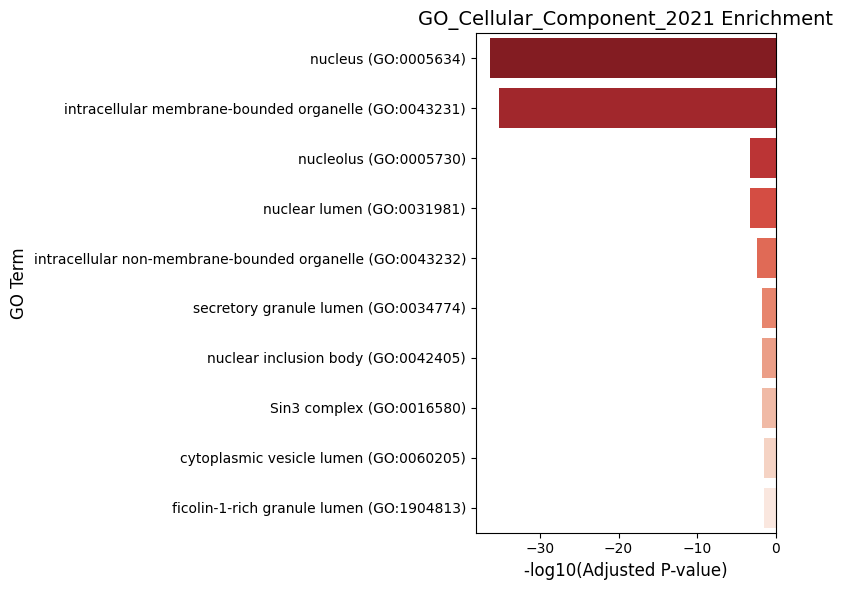

C:\Users\sherl\AppData\Local\Temp\ipykernel_7928\3808193800.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


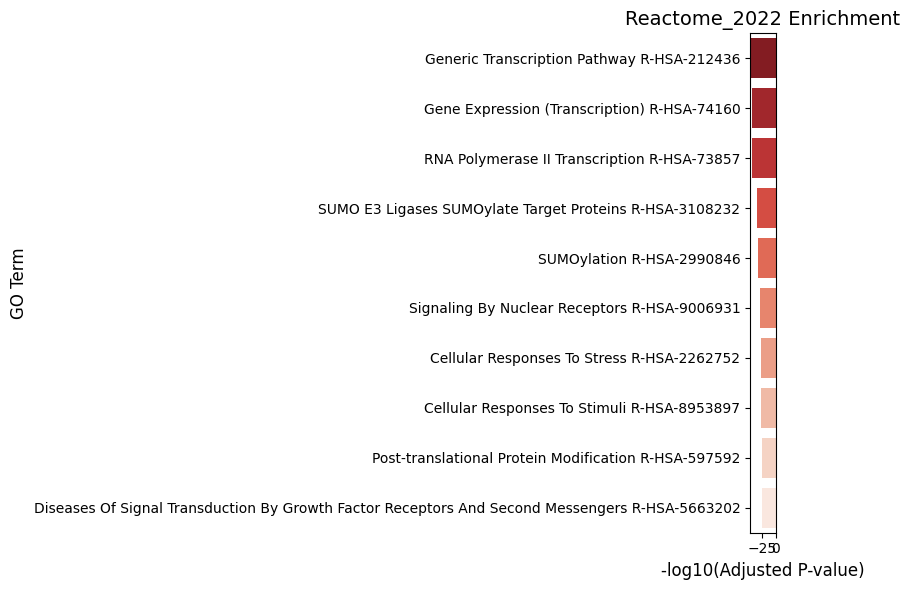

C:\Users\sherl\AppData\Local\Temp\ipykernel_7928\3808193800.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


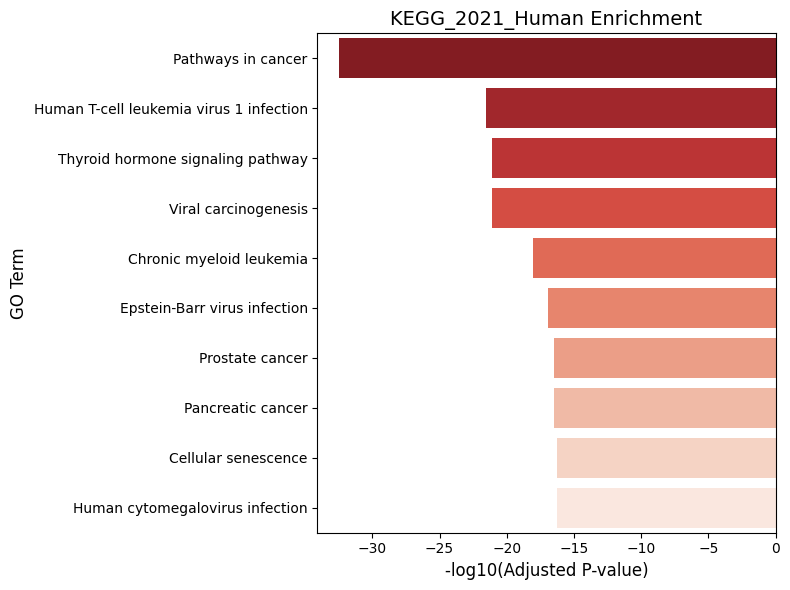

Visualizing original genes enrichment...


C:\Users\sherl\AppData\Local\Temp\ipykernel_7928\3808193800.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


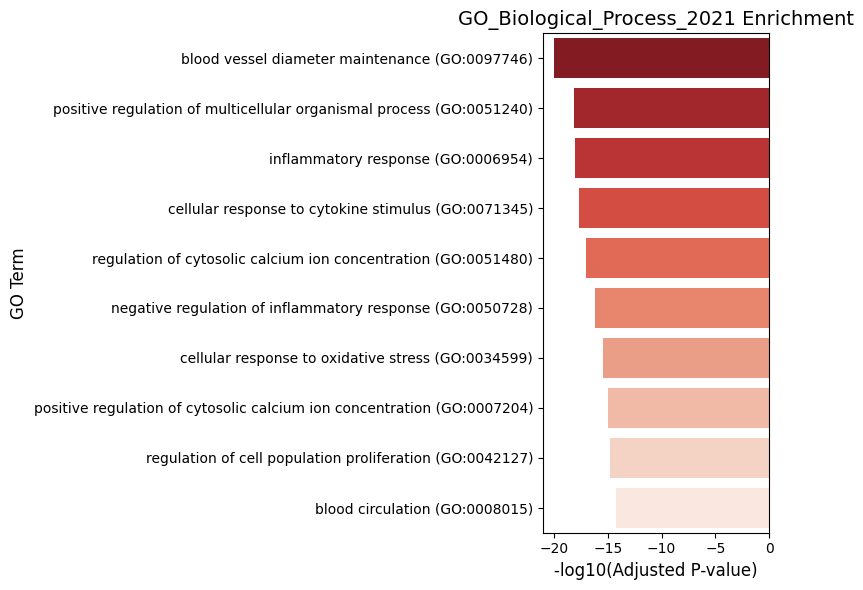

C:\Users\sherl\AppData\Local\Temp\ipykernel_7928\3808193800.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


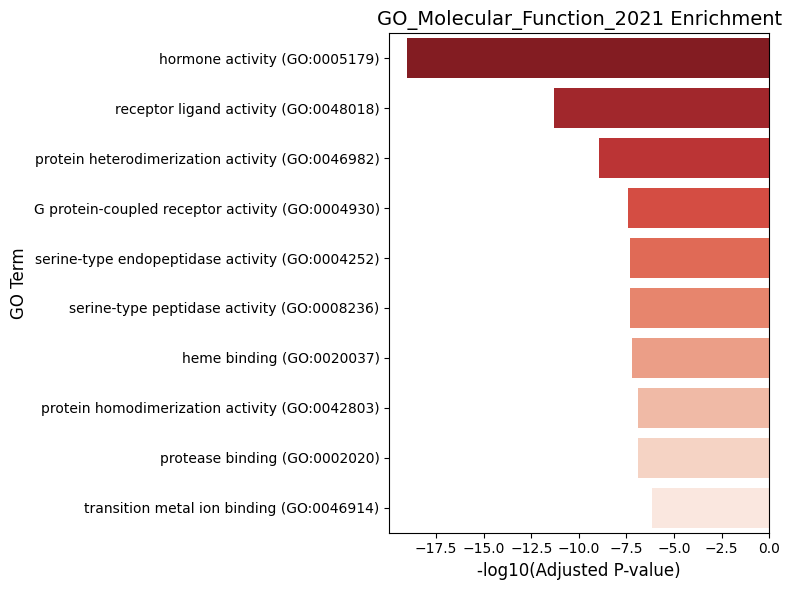

C:\Users\sherl\AppData\Local\Temp\ipykernel_7928\3808193800.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


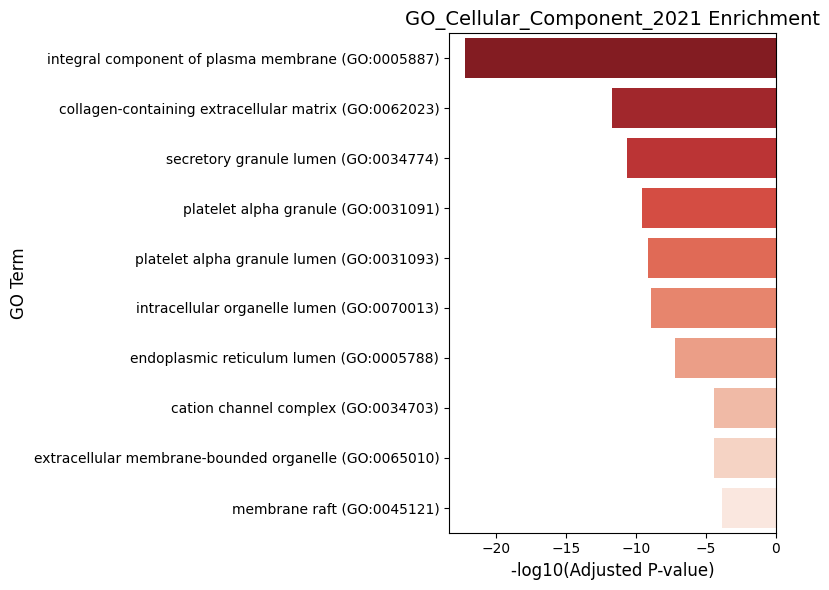

C:\Users\sherl\AppData\Local\Temp\ipykernel_7928\3808193800.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


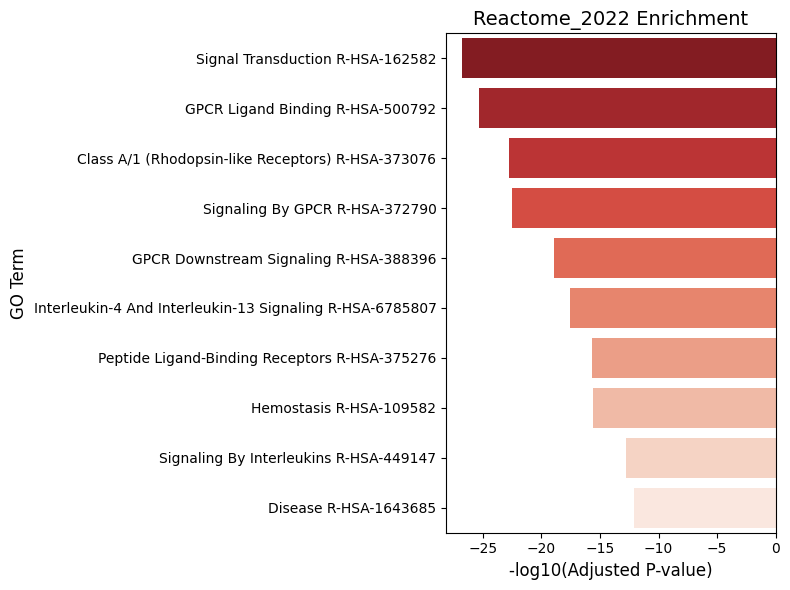

C:\Users\sherl\AppData\Local\Temp\ipykernel_7928\3808193800.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


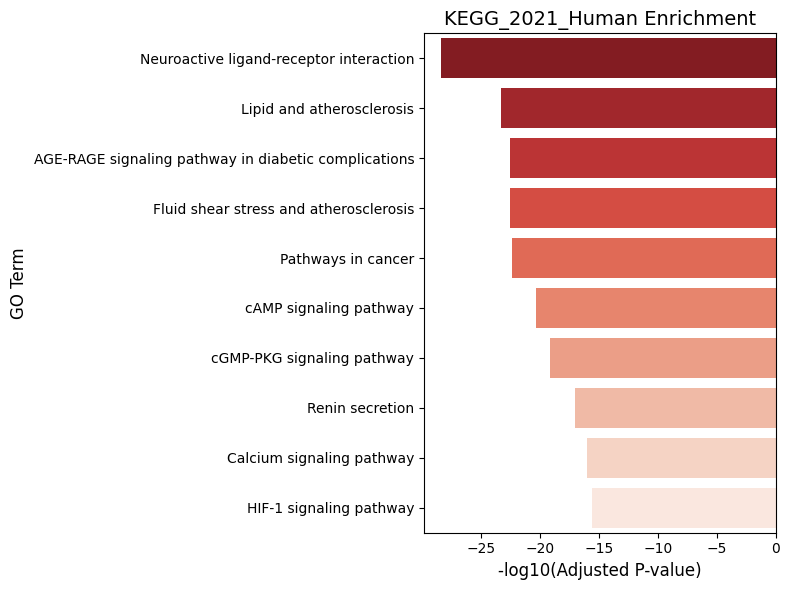

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to create bar plots for enrichment results
def create_enrichment_plot(enrichment_results, library_name, title, output_file):
    # Filter significant terms (adjusted p-value < 0.05)
    significant_terms = enrichment_results[enrichment_results["Adjusted P-value"] < 0.05]
    if significant_terms.empty:
        print(f"No significant terms found for {library_name}.")
        return

    # Sort by significance
    significant_terms = significant_terms.sort_values("Adjusted P-value")
    
    # Select top 10 terms
    top_terms = significant_terms.head(10)
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x=-top_terms["Adjusted P-value"].apply(lambda x: -np.log10(x)), 
        y=top_terms["Term"], 
        palette="Reds_r"
    )
    plt.xlabel("-log10(Adjusted P-value)", fontsize=12)
    plt.ylabel("GO Term", fontsize=12)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    
    # Save plot to file
    plt.savefig(output_file)
    plt.show()

# Visualize enrichment results for both putative and original genes
def visualize_enrichment_results(enrichment_results, output_prefix):
    for library_name, results in enrichment_results.items():
        title = f"{library_name} Enrichment"
        output_file = f"{output_prefix}_{library_name}_enrichment.png"
        create_enrichment_plot(results, library_name, title, output_file)

# Visualize results for putative genes
print("Visualizing putative genes enrichment...")
visualize_enrichment_results(putative_results, "results/putative")

# Visualize results for original genes
print("Visualizing original genes enrichment...")
visualize_enrichment_results(original_results, "results/original")


# Part 4: Drug repurposing


## Part 4.1: Drug identification



Load Top 20 Genes

In [46]:
# Load the ranked genes
top_genes = pd.read_csv("results/top_gene.csv", header=None, names=["Gene"])

# Select the top 20 putative disease genes
top_20_genes = top_genes.head(20)
print("Top 20 Putative Disease Genes:")
print(top_20_genes)

Top 20 Putative Disease Genes:
        Gene
0   HSP90AA1
1        SP1
2       ARNT
3      PSMD2
4      MAPK1
5      THBS1
6      STUB1
7      NCOA3
8      NCOA1
9      SMAD3
10    SQSTM1
11     CALM1
12      AKT1
13      GNG8
14       FGA
15     KEAP1
16     PSMD4
17  PPP1R13L
18       VCP
19     NFKB2


Load DGIdb Data and Filter for Approved Drugs



In [50]:
# Load DGIdb interactions file
dgidb_df = pd.read_csv("content/interactions.tsv", sep='\t')

# Filter for approved drugs
approved_drugs_df = dgidb_df[dgidb_df['approved'] == True]

# Associate drugs with the top 20 genes
drug_hits = approved_drugs_df[approved_drugs_df['gene_name'].isin(top_20_genes['Gene'])]

# Display the drug-gene associations
print("Drugs associated with the top 20 putative genes:")
drug_hits.head(20)

Drugs associated with the top 20 putative genes:


,gene_claim_name,gene_concept_id,gene_name,interaction_source_db_name,interaction_source_db_version,interaction_type,interaction_score,drug_claim_name,drug_concept_id,drug_name,approved,immunotherapy,anti_neoplastic
260,KEAP1,hgnc:23177,KEAP1,JAX-CKB,10-Apr-24,NaN,0.095468,Sapanisertib,rxcui:2395271,SAPANISERTIB,True,False,True
483,KEAP1,hgnc:23177,KEAP1,JAX-CKB,10-Apr-24,NaN,0.052949,Fluorouracil,rxcui:4492,FLUOROURACIL,True,False,True
598,HSP90AA1,hgnc:5253,HSP90AA1,DTC,9/2/20,NaN,0.020118,TETRACYCLINE,rxcui:10395,TETRACYCLINE,True,False,False
1996,SMAD3,hgnc:6769,SMAD3,DTC,9/2/20,NaN,0.020845,PYRITHIONE,rxcui:35100,PYRITHIONE,True,False,False
2107,MAPK1,hgnc:6871,MAPK1,DTC,9/2/20,NaN,0.050007,ZALCITABINE,rxcui:3363,ZALCITABINE,True,False,False
2326,SMAD3,hgnc:6769,SMAD3,DTC,9/2/20,NaN,0.038215,TRICLOSAN,rxcui:10795,TRICLOSAN,True,False,False
2621,MAPK1,hgnc:6871,MAPK1,NCI,14-Sep-17,NaN,0.016669,L-DOPA,rxcui:6375,LEVODOPA,True,False,False
2785,AKT1,hgnc:391,AKT1,PharmGKB,4/5/24,NaN,0.023111,nortriptyline,rxcui:7531,NORTRIPTYLINE,True,False,False
4922,CALM1,hgnc:1442,CALM1,ChEMBL,33,inhibitor,2.917093,PRENYLAMINE,rxcui:8674,PRENYLAMINE,True,False,False
5107,PSMD4,hgnc:9561,PSMD4,ChEMBL,33,inhibitor,0.178598,IXAZOMIB,rxcui:1723735,IXAZOMIB,True,False,False


**Rank** the Drugs

In [51]:
# Count the number of genes associated with each drug
drug_ranking = drug_hits.groupby('drug_name')['gene_name'].count().reset_index()

# Sort by the count in descending order
drug_ranking = drug_ranking.rename(columns={'gene_name': 'Gene_Count'})
drug_ranking = drug_ranking.sort_values(by='Gene_Count', ascending=False)

# Save the ranking to a CSV file
drug_ranking.to_csv("drug_ranking.csv", index=False)

# Display the ranked drugs
print("Ranked drugs based on association with top 20 genes:")
drug_ranking.head(20)

Ranked drugs based on association with top 20 genes:


,drug_name,Gene_Count
18,BORTEZOMIB,8
24,CAPIVASERTIB,7
26,CARFILZOMIB,7
61,ETOPOSIDE,3
85,IXAZOMIB CITRATE,3
56,DOXORUBICIN HYDROCHLORIDE,3
77,HEXACHLOROPHENE,3
128,THIMEROSAL,3
34,CLIOQUINOL,3
96,MICONAZOLE NITRATE,2


## Part 4.2: Clinical Trials validation

### Clinical Trials Validation

| **Drug Name**   | **Condition/Disease** | **Number of Trials** | **Example Trial Title**                                                                                  | **NCT ID**     | **Status**    |
|------------------|-----------------------|-----------------------|----------------------------------------------------------------------------------------------------------|----------------|---------------|
| DOXORUBICIN HYDROCHLORIDE         | High Blood Pressure  | 3                     | Liver Resection for Patients With Hepatocellular Carcinoma and Clinically Significant Portal Hypertension                                               | NCT06245798    | Completed     |
| TAMOXIFEN      | High Blood Pressure  | 2                     | Tamoxifen Therapy to Treat Pulmonary Arterial Hypertension                            | NCT03528902    | Completed     |
| EVEROLIMUS        | High Blood Pressure         | 2                     | Effects of the Use of "de Novo" Everolimus in Renal Tranplant Population Stroke, and Heart Attacks       | NCT01663805 |Unknownd |
